## ISMD (Inversed Synthesizable Molecular Design) Totorial

This tutorial will proceed as follow:

1. initial setup and data preparation
2. descriptor preparation for forward model (likelihood)
3. forward model (likelihood) preparation
4. proposal mdoel preparation 
5. a complete ismd run

### 1.1 import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xenonpy
import onmt
from xenonpy.descriptor import Fingerprints
from xenonpy.contrib.ismd import GaussianLogLikelihood
from xenonpy.contrib.ismd import ReactionDescriptor
from xenonpy.contrib.ismd import ReactantPool
from xenonpy.contrib.ismd import Reactor
from xenonpy.contrib.ismd import ISMD

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

### 1.2 load data

In [2]:
# ground truth data
ground_truth_path = "/home/qiz/data/lab_database/ismd_data/STEREO_id_reactant_product_xlogp_tpsa.csv"
data = pd.read_csv(ground_truth_path)[:1000]
data.head()

,reactant_index,reactant,product,XLogP,TPSA
0,12163.22445,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,863.20896,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,249087,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,153658.23440,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,297070,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


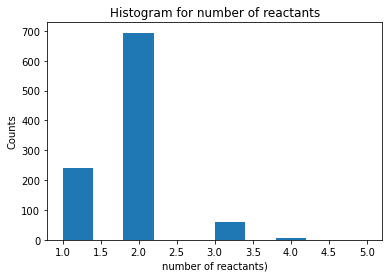

In [3]:
count = [len(reactants.split('.')) for reactants in data["reactant_index"]]
plt.hist(count, bins=10)  # arguments are passed to np.histogram
plt.title('Histogram for number of reactants')
plt.xlabel('number of reactants)')
plt.ylabel('Counts')
plt.show()

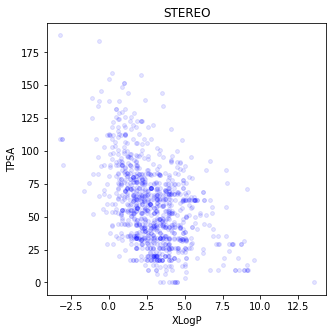

In [4]:
# check target properties: XLogP & TPSA
plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'],data['TPSA'],s=15,c='b',alpha = 0.1)
plt.title('STEREO')
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.show()

In [5]:
# take sub dataset from the whole data

# randomly choose

In [6]:
# reactant pool
reactant_pool_path = "/home/qiz/data/lab_database/ismd_data/STEREO_pool_df.csv"

reactant_pool = pd.read_csv(reactant_pool_path)

# show the first three elements in the reactant pool
reactant_pool.head()

,id,SMILES
0,0,O=C(Cl)Oc1ccc(Cc2ccc(C(F)(F)F)cc2)cc1
1,1,CCc1cc(C2CCN(C(=O)OC(C)(C)C)CC2)ccc1Nc1ncc(C(F...
2,2,CC(NC(=O)OCc1ccccc1)C(C)NC(=O)c1ccccc1O
3,3,OC[C@H]1NCC[C@@H]1O
4,4,C#CCCN1C(=O)c2ccccc2C1=O


In [7]:
# similarity matrix of reactant pool
sim_matrix_path = "/home/qiz/data/lab_database/ismd_data/ZINC_sim_sparse.npz"
reactant_pool_sim = scipy.sparse.load_npz(sim_matrix_path).tocsr()

# show the list of indice whose molecule is similar to the first one in the reactant pool
print(reactant_pool_sim[0,:].nonzero()[1].tolist())

[0, 9850, 11897, 23561, 25594, 28947, 30750, 31361, 44204, 46017, 76945, 118108, 145556, 145734, 164311, 186671, 205326, 207174, 209595, 215653, 218310, 222491, 224002, 232232, 233447, 252758, 274284, 278177, 288659, 291331, 294003, 294172, 300867, 306289, 307663, 331897, 334538, 335455, 343644, 360531, 364663, 365676, 376086, 378821, 412563, 442160, 443411, 452943, 460860, 479253, 487849, 491373, 499241, 500259, 523929, 525478, 528040, 559770, 567735, 568783, 582833, 584542, 586316, 588491, 595094, 599275, 601808, 603887, 617189]


### 2.1 descripter
data is transformed in the following flow:

index of reactant -> smiles of reactant -> smiles of product -> fingerprint of product

In [8]:
# take some samples (index of reactant)
samples = data[["reactant_index"]].sample(n=100)
print(samples)

    reactant_index
635   32772.396958
865          68076
455    624179.9351
863          39600
631   178908.23440
..             ...
421           2627
462   446095.23974
2           249087
669    360977.9351
240    44651.69609

[100 rows x 1 columns]


### 2.1.1 index of reactant -> smiles of reactant
Obtain the smiles by ReactantPool module via index

Note: the ReactantPool also used as proposal model in step 4

In [9]:
pool_obj = ReactantPool(pool_data=reactant_pool, similarity_matrix=reactant_pool_sim, splitter='.')

In [10]:
pool_obj.index2reactant(samples)

['CCOC(C)=O.COc1ccc2c(c1OC)CN(C)CCc1cc(OCc3ccccc3)ccc1CC2',
 'O=C1CCC2(CC1)CCC(=O)c1ccccc12',
 'Cc1cccc(C(C)(C)C)c1O.N',
 'N#CC1(c2ccccc2)CCC(=O)CC1',
 'CC(=O)Nc1cccc2c(OC(C)=O)c(S(=O)(=O)[O-])ccc12.O=P(Cl)(Cl)Cl',
 'CN=C=O.O=C(O)C(S)c1ccccc1',
 'COc1ccc([N+](=O)[O-])c(C=Cc2ccccn2)c1',
 'CC(=O)Nc1cccc2c(OC(C)=O)c(S(=O)(=O)Cl)ccc12.[NH4+]',
 'COC(=O)C(C)(Br)CCc1cccc(C(=O)c2ccccc2)c1',
 'CCC(=O)OC(=O)CC.O=CC(Cl)(Cl)Cl',
 'CNCCC=O.Cc1nnc(N=C=O)s1',
 'C=O.CCN(N)C(=O)Nc1nnc(C)s1',
 'CC(=O)C1CCC(C)CC1=O.CCCCCC(C)C(C)(C)c1cc(O)cc(O)c1',
 'CNCCN.O=Cc1ccccc1',
 'CC(=O)c1ccc(O)cc1.O=C(O)c1cccnc1Cl',
 'Nc1cc(Cl)c(O)c(C(=O)O)c1.O=C(CC1CCCCC1=O)c1ccccc1',
 'C=O.CSc1nnc(NC(=O)N(C)N)s1',
 'COc1cccc(C23CCCC(C2)N(C)C3)c1',
 'CCI.COc1cccc(C23CCCC(C2)N(C)C3=O)c1',
 'C=CCBr.O=C1CCC(c2ccc(O)cc2)=NN1',
 'CCCCCC(O)CC[C@H]1CC[C@@H](O)[C@@H]1CCCCCCC(=O)OCC',
 'CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)O',
 'O=C([O-])[O-].On1c(C(F)(F)F)nc2ncc(Cl)cc21',
 'COc1ccc2c(c1)CCC(=O)C2(C)CCCCCl',
 'CC(C)OC(=O)c1ccc2c(c1)Cc1cccnc

### 2.1.2 smiles of reactant -> fingerprint of product

In [11]:
# build molecular transformer (smiles of reactant -> smiles of product)
reactor_path = "/home/qiz/data/lab_database/models/STEREO_mixed_augm_model_average_20.pt"
ChemicalReactor = Reactor()
ChemicalReactor.BuildReactor(model_list=[reactor_path], max_length=100, n_best=1, gpu=0)

In [12]:
# build fingerprint descriptor (smiles of product -> fingerprint of product)

RDKit_FPs = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles')

In [13]:
# build reaction descriptor (index of reactant -> fingerprint of product)
# a combination of reactor and fingerprint descripter

RD = ReactionDescriptor(descriptor_calculator=RDKit_FPs,reactor=ChemicalReactor,reactant_pool=pool_obj)

In [14]:
sample_FPs = RD.transform(samples)
sample_FPs.head()

,maccs:0,maccs:1,maccs:2,maccs:3,maccs:4,maccs:5,maccs:6,maccs:7,maccs:8,maccs:9,...,ecfp3:2038,ecfp3:2039,ecfp3:2040,ecfp3:2041,ecfp3:2042,ecfp3:2043,ecfp3:2044,ecfp3:2045,ecfp3:2046,ecfp3:2047
635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
samples

,reactant_index,reactant_SMILES,product,validate
635,32772.396958,CCOC(C)=O.COc1ccc2c(c1OC)CN(C)CCc1cc(OCc3ccccc...,COc1ccc2c(c1OC)CN(C)CCc1cc(O)ccc1CC2,True
865,68076,O=C1CCC2(CC1)CCC(=O)c1ccccc12,O=C1CCC2(CC1)CCC(=O)c1ccccc12,True
455,624179.9351,Cc1cccc(C(C)(C)C)c1O.N,Cc1cc(N)cc(C(C)(C)C)c1O,True
863,39600,N#CC1(c2ccccc2)CCC(=O)CC1,N#CC1(c2ccccc2)CCC(O)CC1,True
631,178908.23440,CC(=O)Nc1cccc2c(OC(C)=O)c(S(=O)(=O)[O-])ccc12....,CC(=O)Nc1cccc2c(OC(C)=O)c(S(=O)(=O)Cl)ccc12,True
...,...,...,...,...
421,2627,O=C1c2ccccc2C(=O)c2c1cccc2[N+](=O)[O-],Nc1cccc2c1C(=O)c1ccccc1C2=O,True
462,446095.23974,CN(C)C(=O)N(CCl)c1ccccc1.OCCO,CN(C)C(=O)N(COCCO)c1ccccc1,True
2,249087,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,True
669,360977.9351,CCOC(=O)CN1C(Cl)=Nc2cccc(C)c2C1C.N,CCOC(=O)CN1C(N)=Nc2cccc(C)c2C1C,True


### 3 Log-likelihood calculator

Compute the log-likelihood given the samples(index of reactant)

In [16]:
%%time

# set target
prop = ['XLogP', 'TPSA']
target_range = {'XLogP': (5, 10), 'TPSA': (50, 100)}

# build Gaussian likelihood calculator and set the target of region of the properties
likelihood_calculator = GaussianLogLikelihood(descriptor=RD, targets = target_range)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 160 µs


In [17]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[["reactant_index"]], data[prop], test_size=0.33, random_state=42)
print(len(X_train),len(y_train))

670 670


In [27]:
desc = RD.transform(X_train, return_type='df').reset_index(drop=True)

RDKit ERROR: [22:50:49] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [22:50:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [22:50:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 


In [28]:
desc.dropna(inplace=True)

In [29]:
desc

,maccs:0,maccs:1,maccs:2,maccs:3,maccs:4,maccs:5,maccs:6,maccs:7,maccs:8,maccs:9,...,ecfp3:2038,ecfp3:2039,ecfp3:2040,ecfp3:2041,ecfp3:2042,ecfp3:2043,ecfp3:2044,ecfp3:2045,ecfp3:2046,ecfp3:2047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:

# train forward models inside ismd
likelihood_calculator.fit(X_train, y_train)

RDKit ERROR: [22:53:25] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [22:53:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [22:53:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 


In [19]:
y_train_pred = likelihood_calculator.predict(X_train)
y_test_pred = likelihood_calculator.predict(X_test)

RDKit ERROR: [22:54:32] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [22:54:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [22:54:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [22:54:38] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 
RDKit ERROR: [22:54:38] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [22:54:38] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C23CCc4[nH]nc(O)c4C2)c1'


In [24]:
y_train_pred

,XLogP: mean,XLogP: std,TPSA: mean,TPSA: std
703,4.690423,0.623489,34.188421,8.026710
311,2.812964,0.688595,36.415233,8.866735
722,0.454917,0.668055,126.428706,8.600482
629,0.572516,0.677384,37.875555,8.721705
0,0.780761,0.649841,50.752591,8.364802
...,...,...,...,...
106,1.682453,0.670439,63.958352,8.631469
270,2.116396,0.639800,105.366110,8.235183
860,2.134742,0.654002,65.714412,8.419277
435,0.642615,0.651148,115.123553,8.382102


In [34]:
property="XLogP"
min(y_train[property])

-3.1

In [35]:
xy_min = min(min(y_train[property]),min(y_test[property]),min(y_train_pred[property+": mean"]),min(y_test_pred[property+": mean"]))

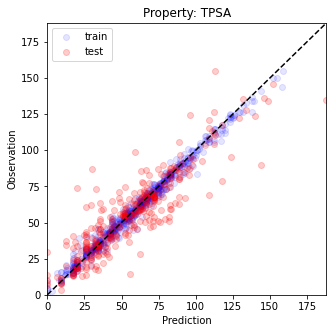

In [38]:
property="TPSA"

xy_min = min(min(y_train[property]),min(y_test[property]),min(y_train_pred[property+": mean"]),min(y_test_pred[property+": mean"]))
xy_max = max(max(y_train[property]),max(y_test[property]),max(y_train_pred[property+": mean"]),max(y_test_pred[property+": mean"]))
plt.figure(figsize=(5,5))
plt.scatter(y_train[property], y_train_pred[property+": mean"], c='b', alpha=0.1, label='train')
plt.scatter(y_test[property], y_test_pred[property+": mean"], c='r', alpha=0.2, label='test')
# plt.text(xy_min+xy_diff*0.7,xy_min+xy_diff*0.05,'MAE: %5.2f' % np.mean(np.abs(y_true - y_pred)),fontsize=12)
plt.title('Property: ' + property)
plt.xlim(xy_min,xy_max)
plt.ylim(xy_min,xy_max)
plt.legend(loc='upper left')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.plot([xy_min,xy_max],[xy_min,xy_max],ls="--",c='k')
plt.show()

In [18]:
valid_partical = training_ll.query('XLogP!="-inf" & TPSA!="-inf" ')
valid_partical

,XLogP,TPSA
0,-24.679663,-0.528917
1,-14.071434,-0.640240
2,-7.426115,-1.765290
3,-4.409783,-0.514426
4,-5.022725,-0.621092
...,...,...
995,-25.712939,-0.000651
996,-17.530361,-0.892845
997,-14.444439,-1.038100
998,-14.444439,-1.038100


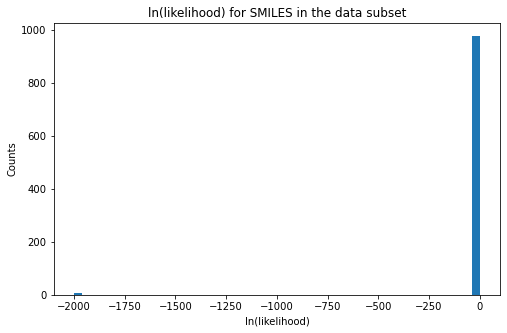

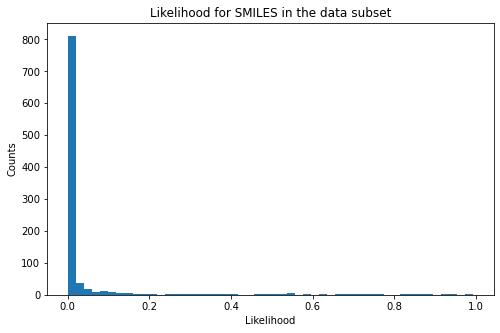

In [21]:

# plot histogram of log-likelihood values
tmp = valid_partical.sum(axis = 1, skipna = True)

plt.figure(figsize=(8,5))
plt.hist(tmp, bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()

In [22]:
# predicted properties of samples
pred = likelihood_calculator.predict(data)
print(pred.head())

RDKit ERROR: [10:58:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [10:58:09] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:58:09] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [10:58:09] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [10:58:09] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [10:58:09] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C23CCc4[nH]nc(O)c4C2)c1'


   XLogP: mean  XLogP: std  TPSA: mean  TPSA: std
0     0.768960    0.640034   52.334120  10.346404
1     1.869018    0.651625   50.718846  10.548338
2     2.878999    0.654422   39.950279  10.582209
3     3.515118    0.659330   52.648232  10.688316
4     3.488992    0.609510   50.955043  10.184122


In [23]:
valid_pred = pred[pred.index.isin(valid_partical.index)]
valid_pred

,XLogP: mean,XLogP: std,TPSA: mean,TPSA: std
0,0.768960,0.640034,52.334120,10.346404
1,1.869018,0.651625,50.718846,10.548338
2,2.878999,0.654422,39.950279,10.582209
3,3.515118,0.659330,52.648232,10.688316
4,3.488992,0.609510,50.955043,10.184122
...,...,...,...,...
995,0.585666,0.652821,84.026390,10.581315
996,1.545666,0.633134,47.662248,10.214803
997,2.103862,0.593594,46.325070,9.820705
998,2.103862,0.593594,46.325070,9.820705


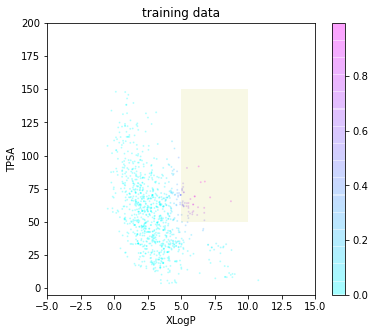

In [24]:
# check the predicted likelihood
dot_scale = 0.1
l_std = np.sqrt(valid_pred['XLogP: std']**2+valid_pred['TPSA: std']**2)

plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((target_range["XLogP"][0],target_range["TPSA"][0]),target_range["XLogP"][1]-target_range["XLogP"][0],target_range["TPSA"][1]-target_range["TPSA"][0],fc='y',alpha=0.1)
plt.gca().add_patch(rectangle)
im = plt.scatter(valid_pred['XLogP: mean'], valid_pred['TPSA: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
plt.title('training data')
plt.xlim([-5,15])
plt.ylim([-5,200])
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.colorbar(im)
plt.show()

In [28]:
# compute the log likelihood of samples
likelihood_prediction = likelihood_calculator(samples, **target_range)
print(likelihood_prediction.head())

      XLogP      TPSA
0 -6.256657 -5.910179
1 -5.685817 -0.034789
2 -7.279272 -0.016470
3 -2.659760 -0.806802
4 -3.162546 -0.487631


In [29]:
likelihood_prediction.iloc[62]

XLogP   -0.392912
TPSA    -1.443603
Name: 62, dtype: float64

### 4 proposal model

proposal from the given reactant pool, sample(index of reactant) is modified by randomly changing one reactant to a similar one.

In [30]:
# proposal based on samples
new_samples = pool_obj.proposal(samples)
print(samples)
print(new_samples)

         reactant_index                                    reactant_SMILES  \
0          585613.35655                         CCN=C(CC)CC.O=C(Cl)C(Cl)Cl   
1   288454.34937.355539          CCOC(=O)OCC.CI.N#CCc1ccc2c(c1)Cc1cccnc1O2   
2         489280.577533         COc1ccc(C(=O)Nc2ccccc2C=O)cc1.[Li]c1ccccn1   
3          552414.43401  CCSc1ccc2c(c1)C(CC(=O)Oc1ccc([N+](=O)[O-])cc1)...   
4                384868             CCOC(=O)CC=C(C)c1cccc(C(=O)c2ccccc2)c1   
..                  ...                                                ...   
95               400127                 OC1(c2ccc(Cl)cc2)c2ccccc2C2=NCCN21   
96          3290.296178  COc1ccc(C(=O)Cl)cc1.O=[N+]([O-])c1cc2c(cc1C=Cc...   
97         31649.205951                 Nc1ccc(C(=O)O)cc1.O=C(Cl)C1CCCCCC1   
98        110011.139923       COc1ccc2cc(C(Cl)C(=O)O)ccc2c1.OC(=S)c1ccccc1   
99         32715.278022                CC(=O)O.N#Cc1ccc2oc3ncccc3c(=O)c2c1   

                                         product  validate  
0 

### 5 complete run of ismd

In [32]:
# set up initial reactants
cans = [smi for i, smi in enumerate(data['reactant_index'])
        if (data['XLogP'].iloc[i] < 2.5)]
sample_index = np.random.choice(cans, 10)
init_samples = pd.DataFrame({"reactant_index":sample_index})
print(init_samples)

       reactant_index
0  374520.305322.8609
1       454237.275300
2         129223.9206
3        17387.182484
4              605383
5        18346.574406
6       387984.390442
7               10271
8         9818.621851
9        241105.11328


In [33]:
# set up annealing schedule
beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)

Number of steps: 50
[0.01       0.02       0.03       0.04       0.05       0.06
 0.07       0.08       0.09       0.1        0.11       0.12
 0.13       0.14       0.15       0.16       0.17       0.18
 0.19       0.2        0.21       0.23111111 0.25222222 0.27333333
 0.29444444 0.31555556 0.33666667 0.35777778 0.37888889 0.4
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [34]:
samples.sample(n=10)

,reactant_index,reactant_SMILES,product,validate
24,465397,CC#CC(O)C1=C(C)C=CCC1(C)C,C/C=C\C(=O)C1=C(C)C=CCC1(C)C,True
96,3290.296178,COc1ccc(C(=O)Cl)cc1.O=[N+]([O-])c1cc2c(cc1C=Cc...,COc1ccc(C(=O)Nc2cc3c(cc2C=Cc2ccccn2)OCO3)cc1,True
47,301612.454257,Cc1n[nH]c(Br)c1Br.O=[N+]([O-])O,Cc1n[nH]c(Br)c1[N+](=O)[O-],True
46,68076,O=C1CCC2(CC1)CCC(=O)c1ccccc12,O=C1CCC2(CC1)CCC(=O)c1ccccc12,True
80,2627,O=C1c2ccccc2C(=O)c2c1cccc2[N+](=O)[O-],Nc1cccc2c1C(=O)c1ccccc1C2=O,True
77,432938,O=C(O)CCCCCCC1C(=O)CC(=O)C1=O,O=C(O)CCCCCCC1=CC(=O)C1=O,True
41,609016.11328,CC(CC(C)C)=NNC(C)(C)C.ClCl,CC(C)CC(C)(Cl)N=NC(C)(C)C,True
83,309436.6167,Cc1cc(O)c(S)c(=O)o1.OC12CC3CC(CC(C3)C1)C2,Cc1cc(O)c(SC23CC4CC(CC(C4)C2)C3)c(=O)o1,True
10,52069.22995,COc1cccc(Cl)c1Cl.O=C(Cl)CCCCCBr,COc1ccc(C(=O)CCCCCBr)c(Cl)c1Cl,True
1,288454.34937.355539,CCOC(=O)OCC.CI.N#CCc1ccc2c(c1)Cc1cccnc1O2,CCOC(=O)C(C)(C#N)c1ccc2c(c1)Cc1cccnc1O2,True


In [35]:
# set up likelihood and modifier models in iQSPR
ismd = ISMD(estimator=likelihood_calculator, modifier=pool_obj)
step = 0
np.random.seed(201906) # fix the random seed
# main loop of iQSPR
ismd_samples, ismd_loglike, ismd_prob, ismd_freq = [], [], [], []
for s, ll, p, freq in ismd(init_samples, beta, yield_lpf=True):
    step += 1
    print(step)
    ismd_samples.append(s)
    ismd_loglike.append(ll)
    ismd_prob.append(p)
    ismd_freq.append(freq)
# record all outputs
ismd_results = {
    "samples": ismd_samples,
    "loglike": ismd_loglike,
    "prob": ismd_prob,
    "freq": ismd_freq,
    "beta": beta
}


1
2


RDKit ERROR: [11:30:04] Can't kekulize mol.  Unkekulized atoms: 2 3 5 13 14 15 16
RDKit ERROR: 


3
4


RDKit ERROR: [11:30:05] Can't kekulize mol.  Unkekulized atoms: 11 12 15
RDKit ERROR: 


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [27]:
# have a look at the result
ismd_result_df = pd.DataFrame(ismd_results)
ismd_result_df.head()

,samples,loglike,prob,freq,beta
0,reactant_index ...,XLogP TPSA 0 -14.305697 -...,"[0.11145919716902213, 0.11661211757127608, 2.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.01
1,reactant_index ...,XLogP TPSA 0 -7.942146 -10.56178...,"[0.10609689830518268, 0.10756918659286474, 0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 2]",0.02
2,reactant_index ...,XLogP TPSA 0 -13.401643 -1.03740...,"[0.10787539637064425, 0.09183688979615266, 0.0...","[1, 1, 1, 1, 1, 1, 2, 1, 1]",0.03
3,reactant_index ...,XLogP TPSA 0 -4.303701 ...,"[0.1540829353539327, 0.1497046612893601, 3.582...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.04
4,reactant_index ...,XLogP TPSA 0 -2.439217 -25.60360...,"[0.04311414521397201, 0.16007459621323933, 0.1...","[1, 1, 1, 1, 2, 1, 1, 1, 1]",0.05


In [28]:
ismd_result_df['samples'][0]

,reactant_index,reactant_SMILES,product,validate
0,12295.36295,CC1CCC(=O)C(CC(=O)c2ccccc2)C1.Nc1ccc(O)c(C(=O)...,CC1CCc2c(cc(-c3ccccc3)n2-c2ccc(O)c(C(=O)O)c2)C1,True
1,132260,CCCCCC(C)(O)C(C)(C)c1cc(OC)cc(OC)c1,CCCCCC(C)(O)C(C)(C)c1cc(OC)cc(OC)c1,True
2,1504.32715.212539,CC(=O)C1CCCCC1=O.CC(=O)O.CCCCCC(C)C(C)c1cc(O)c...,CCCCCC(C)C(C)c1cc(O)c2c3c(c(C)c2c1)CCCC3,False
3,15047.87024,ICCCCCI.NC1CCC2(CCc3ccccc3C2)CC1,c1ccc2c(c1)CCC1(CCC(N3CCCCC3)CC1)C2,True
4,163405.328890,Cc1ccc(S(=O)(=O)NCCNC(C)C)cc1.O=C(O)c1ccccc1C(...,Cc1ccc(S(=O)(=O)NCCN(C(=O)c2ccccc2C(=O)c2ccccc...,True
5,191348.19854,COc1c(CCC(=O)O)cccc1C(=O)c1ccc(Cl)cc1.O=S(Cl)Cl,COc1c(CCC(=O)Cl)cccc1C(=O)c1ccc(Cl)cc1,True
6,195000.115955,CCCCCC(O)/C=C/I.COc1ccc(CC(Cl)(c2ccccc2)c2cccc...,CCCCCC(/C=C/I)OC(Cc1ccc(OC)cc1)(c1ccccc1)c1ccccc1,True
7,207094.539309,O=C(O)CC(=O)O.O=CCc1cccc(C(=O)c2ccc(Cl)cc2)c1O,O=C(O)C=CCc1cccc(C(=O)c2ccc(Cl)cc2)c1O,True
8,36295.150865,Nc1ccc(O)c(C(=O)O)c1.O=C(CC1CCCCC1=O)c1ccc(Br)cc1,O=C(O)c1cc(-n2c(-c3ccc(Br)cc3)cc3c2CCCC3)ccc1O,True
9,391266,CCCCCC(CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC)OC...,CCCCCC(O)CC[C@H]1CCC(=O)[C@@H]1CCCCCCC(=O)OCC,True


In [29]:
ismd_result_df['loglike'][0]

,XLogP,TPSA
0,-14.305697,-10.018233
1,-17.731557,-2.072912
2,-1000.000000,-1000.000000
3,-10.422158,-0.469796
4,-8.613701,-20.029711
5,-9.541776,-5.302802
6,-47.169153,-0.332215
7,-8.514424,-11.767595
8,-21.199962,-10.752987
9,-18.133373,-9.874892


In [30]:
ismd_result_df['prob'][0]

array([1.11459197e-01, 1.16612118e-01, 2.92997394e-10, 1.27482403e-01,
       1.06747236e-01, 1.22541788e-01, 8.84010819e-02, 1.16056563e-01,
       1.03272217e-01, 1.07427396e-01])